In [1]:
import pandas as pd
import torch
from transformers import CamembertTokenizer, CamembertModel
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# charger le modèle français
nlp = spacy.load("fr_core_news_sm")


In [2]:
def lemmatize_text(text):
    """lemmatiser les textes avec spacy"""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


In [3]:
def match_target_word(text, target_word):
    """faire correspondre le mot cible,
    en incluant ses formes plurielles éventuelles"""
    doc = nlp(text)
    matches = [
        token for token in doc
        if token.lemma_ == target_word and token.pos_ in ["NOUN", "VERB", "ADJ"]
    ]
    return len(matches) > 0
    # retourne True, si au moins 1 correspondance est trouvée



In [4]:
def preprocess_and_embed(texts, ids, word, tokenizer, model, batch_size=8):
    """prétraiter le textes,
    obtenir les embeddings du mot cible"""
    word_embeddings = []
    review_embeddings = []
    matched_ids = []
    # sauvegarder les IDs correspondants

    # encoder par lot
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_ids = ids[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

        # obtenir la position du mot cible dans chaq texte
        word_ids = [next((i+1 for i, token in enumerate(tokenizer.tokenize(text)) if word in token), None) for text in batch_texts]

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state

            # extraire les embeddings du mot cible
            # enregistrer les indices
            for idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    word_embeddings.append(hidden_states[idx, word_id].numpy())
                    review_embeddings.append({'id': batch_ids[idx], 'embedding': hidden_states[idx, word_id].numpy()})
                    matched_ids.append(batch_ids[idx])

    return word_embeddings, review_embeddings, matched_ids


In [5]:
def visualize_embeddings(word_embeddings, review_ids):
    """visualiser en 2d les embeddings du mot cible avec t-SNE"""
    word_embeddings_array = np.array(word_embeddings)

    # vérifier le nb d'échantillons
    # ajuster perplexity
    n_samples = len(word_embeddings_array)
    if n_samples < 2:
        print("Not enough samples for visualization")
        return

    perplexity_value = min(30, n_samples - 1)

    # réduction de dimension avec t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    reduced_embeddings = tsne.fit_transform(word_embeddings_array)

    # x_mean, y_mean = np.mean(reduced_embeddings[:, 0]), np.mean(reduced_embeddings[:, 1])
    # x_std, y_std = np.std(reduced_embeddings[:, 0]), np.std(reduced_embeddings[:, 1])
    #
    # reduced_embeddings[:, 0] = 10 * (reduced_embeddings[:, 0] - x_mean) / x_std
    # reduced_embeddings[:, 1] = 10 * (reduced_embeddings[:, 1] - y_mean) / y_std

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', marker='o')

    # vérifier que les IDs des critiques correspondent aux embeddings réduits
    assert len(review_ids) == len(reduced_embeddings), "Mismatch between review_ids and embeddings"

    # affichage des étiquettes des IDs
    for i, review_id in enumerate(review_ids):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(review_id), fontsize=8)

    plt.title("2D Visualization of Word Embeddings (t-SNE)", fontsize=15)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


In [6]:
def analyze_word(word, df, sample_size=100):
    """analyser la polysémie d'un mot"""
    tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
    model = CamembertModel.from_pretrained('camembert-base')
    model.eval()

    relevant_texts = df[df['review'].apply(lambda x: match_target_word(str(x), word))]
    if relevant_texts.empty:
        print(f"No occurrences found for word: {word}")
        return None

    relevant_texts = relevant_texts.sample(n=min(len(relevant_texts), sample_size), random_state=42)

    # obtenir les IDs correspondants, prétraiter les textes
    ids = relevant_texts.iloc[:, 0].values
    processed_texts = [lemmatize_text(re.sub(r'[^\w\s]', ' ', str(text).lower()).strip()) for text in relevant_texts['review']]

    word_embeddings, review_embeddings, matched_ids = preprocess_and_embed(processed_texts, ids, word, tokenizer, model)

    if len(word_embeddings) < 2:
        print(f"Not enough valid embeddings found for word: {word}")
        return None

    # calculer la matrice de similarité cosinus
    embeddings_array = np.array(word_embeddings)
    norm = np.linalg.norm(embeddings_array, axis=1, keepdims=True)
    similarity_matrix = np.dot(embeddings_array / norm, (embeddings_array / norm).T)

    # obtenir le score de polysémie
    polysemy_score = np.std(similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)])

    # visualiser en utilisant les IDs correspondants
    visualize_embeddings(word_embeddings, matched_ids)

    return {
        'word': word,
        'occurrences': len(word_embeddings),
        'polysemy_score': polysemy_score,
        'review_embeddings': review_embeddings
    }


In [7]:
def quick_polysemy_analysis(file_path, target_words, sample_size=100):
    """fonction principale d'analyse"""
    df = pd.read_csv(file_path, header=None, names=['id', 'film-url', 'review', 'polarity'])

    results = []
    for word in target_words:
        print(f"\nAnalyzing word: {word}")
        analysis_result = analyze_word(word, df, sample_size)
        if analysis_result:
            results.append(analysis_result)

    for result in results:
        print(f"\nWord: {result['word']}")
        print(f"Occurrences: {result['occurrences']}")
        print(f"Polysemy score: {result['polysemy_score']:.4f}")

        # afficher les 5 premiers éléments de l'embedding des critiques et leurs IDs
        for review in result['review_embeddings']:
            print(f"Review ID {review['id']}: {review['embedding'][:5]}...")

    return results



In [8]:
# corpus
file_path = 'test.csv'

#### Mots avec un nombre total d'échantillons entre 100 et 250 :
carte, âge, hauteur, tour, cœur


Analyzing word: carte


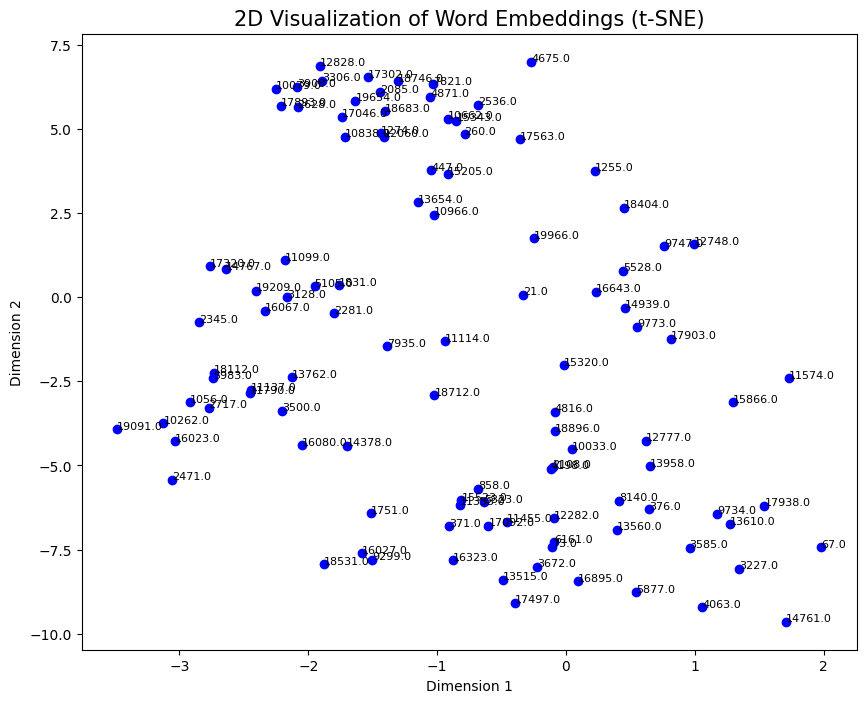


Word: carte
Occurrences: 106
Polysemy score: 0.1653
Review ID 18746.0: [-0.03377141  0.12111717  0.00466347  0.1834575  -0.02014529]...
Review ID 1274.0: [-0.09512544  0.04999993  0.0066408   0.13744202  0.01495318]...
Review ID 371.0: [-0.05287344  0.2702997  -0.08734989  0.00318497  0.04080261]...
Review ID 16067.0: [-0.02103006  0.10484169 -0.02529492 -0.11553866  0.02975475]...
Review ID 18531.0: [-0.02731205  0.3997633  -0.1958402   0.00502031  0.04168026]...
Review ID 13560.0: [ 0.14666404  0.21836664 -0.03262433  0.01700905 -0.01392355]...
Review ID 4675.0: [ 0.04139964  0.22080362 -0.1145056   0.06988306 -0.04752056]...
Review ID 5105.0: [-0.01825004  0.20144969 -0.17033564 -0.07675477  0.05475085]...
Review ID 17903.0: [-0.06308758 -0.04239094 -0.08604573 -0.05472056  0.13227886]...
Review ID 1751.0: [-0.0618601   0.33598918 -0.05488419  0.04038211  0.06862049]...
Review ID 10079.0: [ 0.00566061  0.09188987 -0.02428986  0.19286166 -0.08358805]...
Review ID 9299.0: [-0.0204083

In [9]:
target_words = ['carte']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: âge


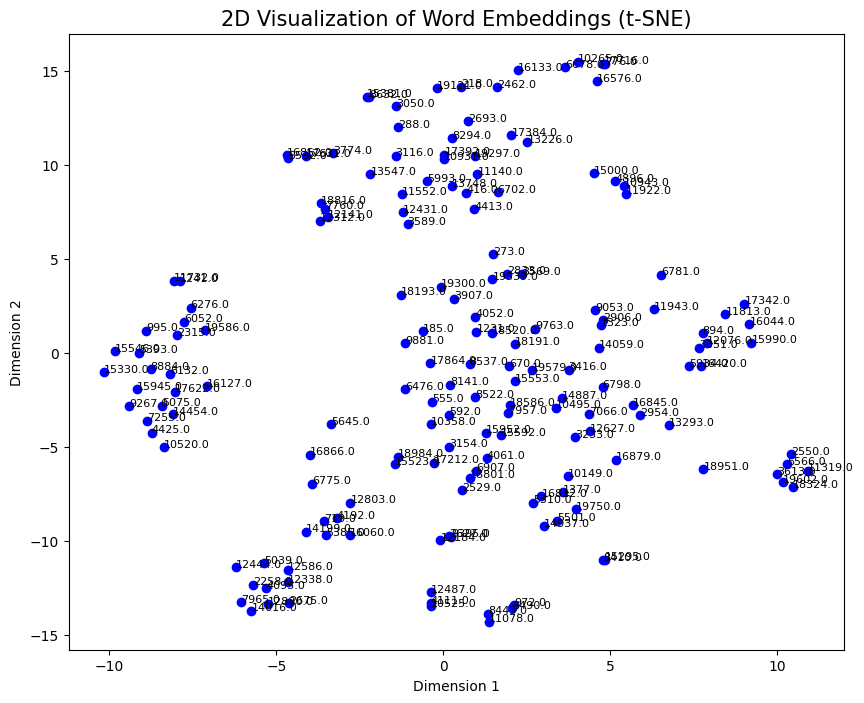


Word: âge
Occurrences: 172
Polysemy score: 0.1619
Review ID 8410.0: [ 0.06740191  0.08351104 -0.1072351   0.08083497  0.06221721]...
Review ID 16127.0: [ 0.22213721  0.19174987 -0.44262338  0.15548767 -0.12768403]...
Review ID 17631.0: [-0.00203051  0.10151993 -0.27384675  0.02912505 -0.06548906]...
Review ID 6476.0: [ 0.17890257  0.09650496 -0.40465227 -0.01870098 -0.0749484 ]...
Review ID 18193.0: [ 0.12865405  0.0298455  -0.3870489  -0.03271086 -0.02778152]...
Review ID 19297.0: [ 0.11918323 -0.05810648 -0.41633886 -0.08241631  0.0280573 ]...
Review ID 9763.0: [ 0.05233319 -0.09371398 -0.37806457  0.11656446 -0.05063258]...
Review ID 16812.0: [ 0.17992352 -0.13111037 -0.34089026  0.0657711   0.05309481]...
Review ID 12880.0: [ 0.13779275 -0.01965408 -0.72044736  0.15250406 -0.00732578]...
Review ID 3154.0: [ 0.21507242  0.08910333 -0.4845505  -0.08804571  0.02628148]...
Review ID 14887.0: [ 0.11469144 -0.15277553 -0.36467582  0.02175387  0.03810605]...
Review ID 12444.0: [ 0.135525

In [10]:
target_words = ['âge']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: hauteur


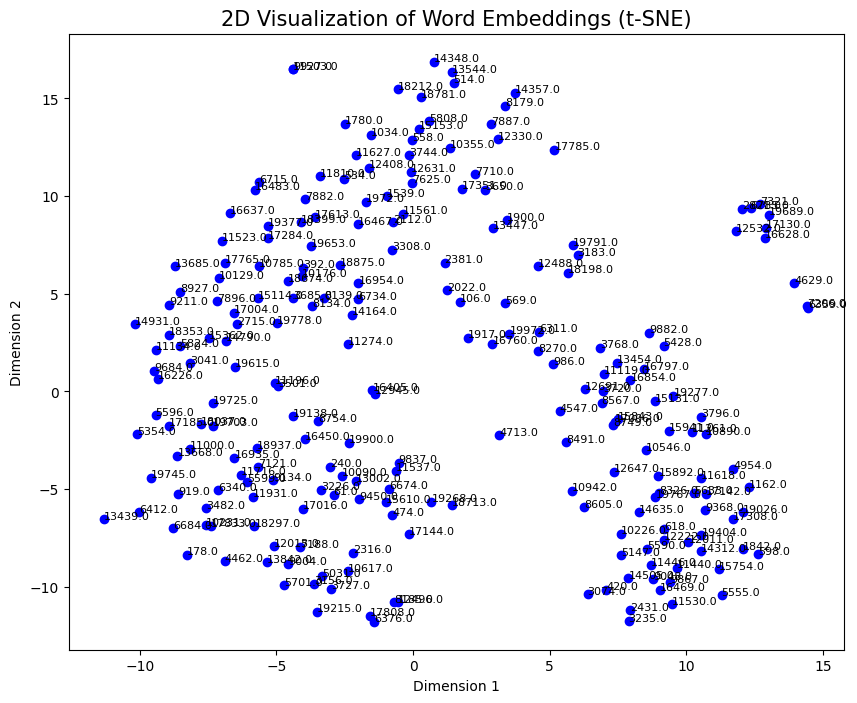


Word: hauteur
Occurrences: 228
Polysemy score: 0.1200
Review ID 19377.0: [ 0.03597611  0.00843945 -0.385304   -0.08009402 -0.18669079]...
Review ID 6376.0: [ 0.10927515 -0.00570228 -0.31283534 -0.07503812 -0.13616522]...
Review ID 558.0: [ 0.029688   -0.15077889 -0.34331158 -0.1426632  -0.17528458]...
Review ID 18198.0: [ 0.07303193  0.1842351  -0.3000268  -0.02397263 -0.07724247]...
Review ID 1034.0: [-0.07269634 -0.1455252  -0.3784905  -0.12639469 -0.14802128]...
Review ID 17808.0: [ 0.10991048 -0.04661405 -0.37142518 -0.06576195 -0.14406717]...
Review ID 2316.0: [ 0.06416219  0.13284713 -0.24696504 -0.01620072 -0.15492049]...
Review ID 17351.0: [-0.08003549  0.10210987 -0.28826204 -0.07568809 -0.12508325]...
Review ID 14164.0: [ 0.11330459 -0.04708654 -0.27710295 -0.07061069 -0.14084958]...
Review ID 11530.0: [ 0.12201709  0.06458674 -0.42769843  0.03314966 -0.10162912]...
Review ID 19215.0: [ 0.08313008  0.01574257 -0.36616555 -0.04454982 -0.13562416]...
Review ID 1842.0: [ 0.1113

In [11]:
target_words = ['hauteur']
results = quick_polysemy_analysis(file_path, target_words, sample_size=300)


Analyzing word: tour


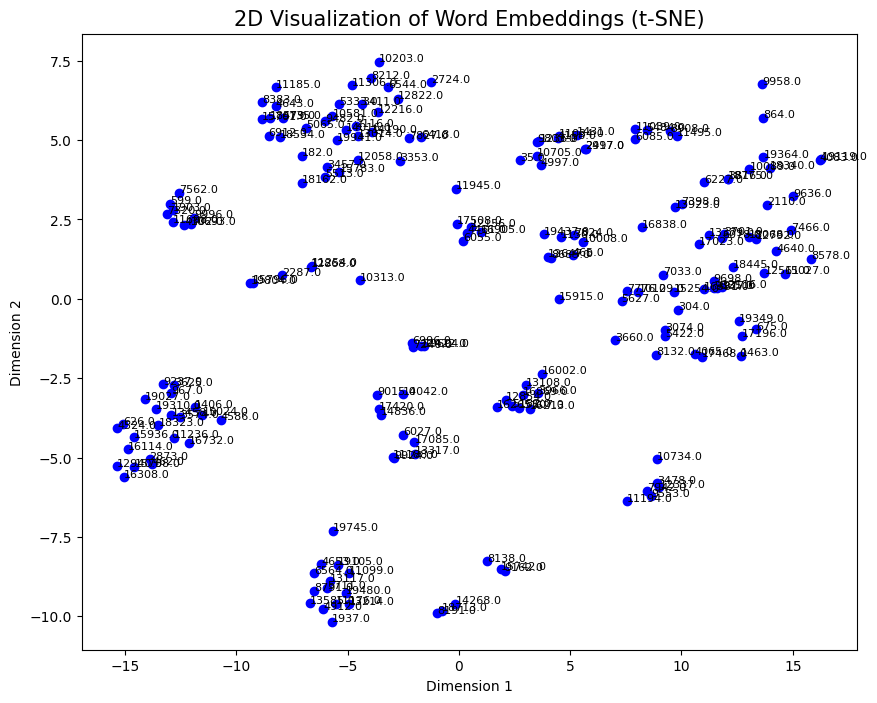


Word: tour
Occurrences: 195
Polysemy score: 0.1518
Review ID 13379.0: [-0.00357594  0.1673318   0.07507176  0.08401991 -0.07432462]...
Review ID 1937.0: [0.11655645 0.00316541 0.04449401 0.18527986 0.03295182]...
Review ID 15796.0: [-0.13271563 -0.20917535  0.09083174  0.20594968  0.08402162]...
Review ID 9958.0: [ 0.02122733  0.03161027 -0.04056808  0.2174626   0.01541233]...
Review ID 7240.0: [-0.01437274  0.04905124 -0.04242359  0.09425826  0.1205221 ]...
Review ID 15742.0: [-0.0491787   0.00448035 -0.17723367 -0.04304194  0.00092395]...
Review ID 5627.0: [-0.00304334  0.2584884  -0.08208004  0.04425107  0.02108374]...
Review ID 1903.0: [-0.10605662 -0.05505075 -0.17693223 -0.02360689  0.07801391]...
Review ID 11188.0: [-0.03415236 -0.07161857  0.23455381  0.14811033  0.06590875]...
Review ID 11185.0: [ 0.09227693  0.04713527 -0.10700665  0.07518344  0.0166681 ]...
Review ID 19105.0: [ 0.11681554 -0.09541713  0.15456592  0.13766713  0.02909844]...
Review ID 2116.0: [-0.00932731  0.

In [12]:
target_words = ['tour']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: cœur


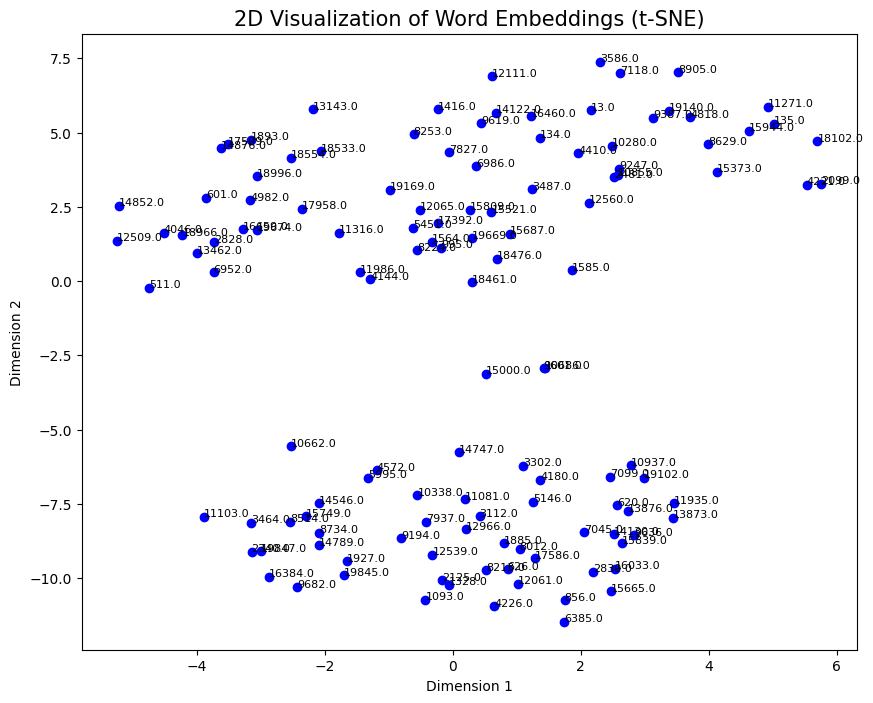


Word: cœur
Occurrences: 124
Polysemy score: 0.1273
Review ID 2125.0: [ 0.19887112  0.05513408 -0.08741158  0.1012312  -0.01904023]...
Review ID 6986.0: [ 0.08807915  0.02018487 -0.15193269  0.15676804 -0.10537289]...
Review ID 4982.0: [ 0.18710035  0.14893255 -0.24797785  0.02311227 -0.05576219]...
Review ID 12065.0: [ 0.15357019 -0.09988959 -0.16901591  0.05985219 -0.07051171]...
Review ID 8629.0: [ 0.05937125 -0.05301052 -0.2544658   0.17149715 -0.06494523]...
Review ID 14789.0: [ 0.1517291  -0.12153603 -0.09631991  0.23283824 -0.02377399]...
Review ID 9194.0: [ 0.18413377 -0.01943808 -0.05212347  0.167292    0.00245604]...
Review ID 19845.0: [ 0.13769071  0.04806459  0.00622741  0.21999818 -0.02270904]...
Review ID 19674.0: [ 0.16771875 -0.11687388 -0.2940442   0.03783661 -0.01845209]...
Review ID 601.0: [ 0.07289074  0.01961704 -0.12407661  0.04029984 -0.12706234]...
Review ID 3586.0: [ 0.0919803   0.2892725  -0.36624214  0.07613061  0.05914434]...
Review ID 15944.0: [-0.0198689  

In [13]:
target_words = ['cœur']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)

#### Mots avec un nombre total d'échantillons ≥ 500 :
critique, histoire, scène


Analyzing word: critique


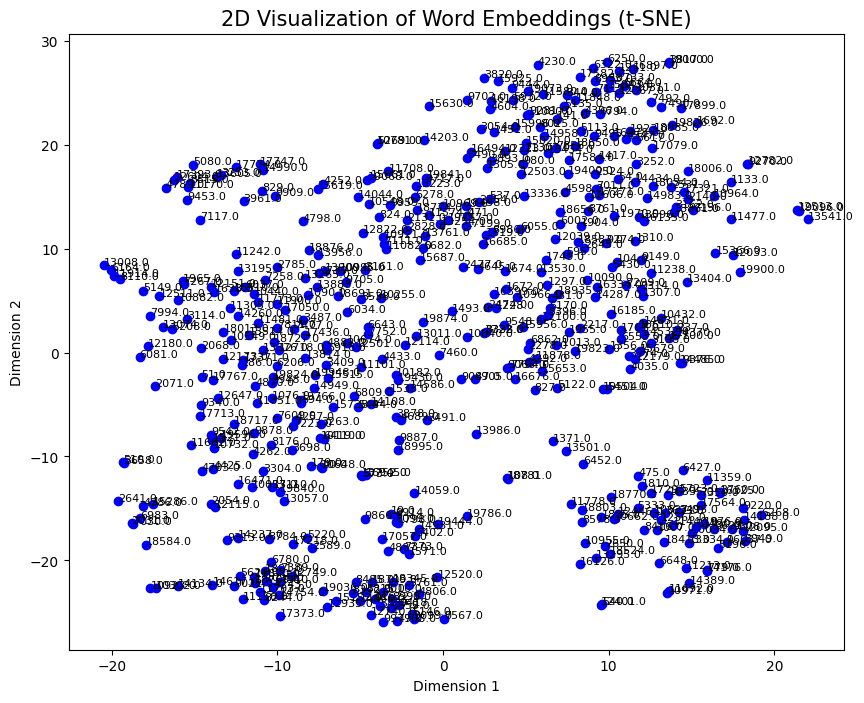


Word: critique
Occurrences: 500
Polysemy score: 0.0720
Review ID 16185.0: [-0.01382873  0.01122437 -0.00585696  0.01883032 -0.09429531]...
Review ID 15996.0: [-0.02343165  0.03229547  0.01313771  0.10836537 -0.13204518]...
Review ID 17293.0: [-0.03334171  0.20162328  0.10669877  0.02982313 -0.10824987]...
Review ID 10182.0: [ 0.02781678 -0.01715288 -0.11034043  0.1189685  -0.12415364]...
Review ID 1310.0: [ 0.02326467  0.07866608 -0.02562229  0.09534492 -0.13592713]...
Review ID 16334.0: [-0.00102542 -0.02897269 -0.16584854  0.07441393 -0.07297367]...
Review ID 13011.0: [-0.03633183 -0.03263077 -0.01333292  0.10441471 -0.1000617 ]...
Review ID 7350.0: [-0.06091013 -0.10624197 -0.06366629  0.0325258  -0.06159934]...
Review ID 10090.0: [-0.05293621 -0.08389452 -0.06538469  0.09880524 -0.0694157 ]...
Review ID 9376.0: [-0.01066144  0.05332845 -0.04994309  0.12751696 -0.19856268]...
Review ID 11238.0: [ 0.03775566 -0.05562027 -0.03334001  0.04516079 -0.14576276]...
Review ID 10110.0: [-0.

In [14]:
target_words = ['critique']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: critique


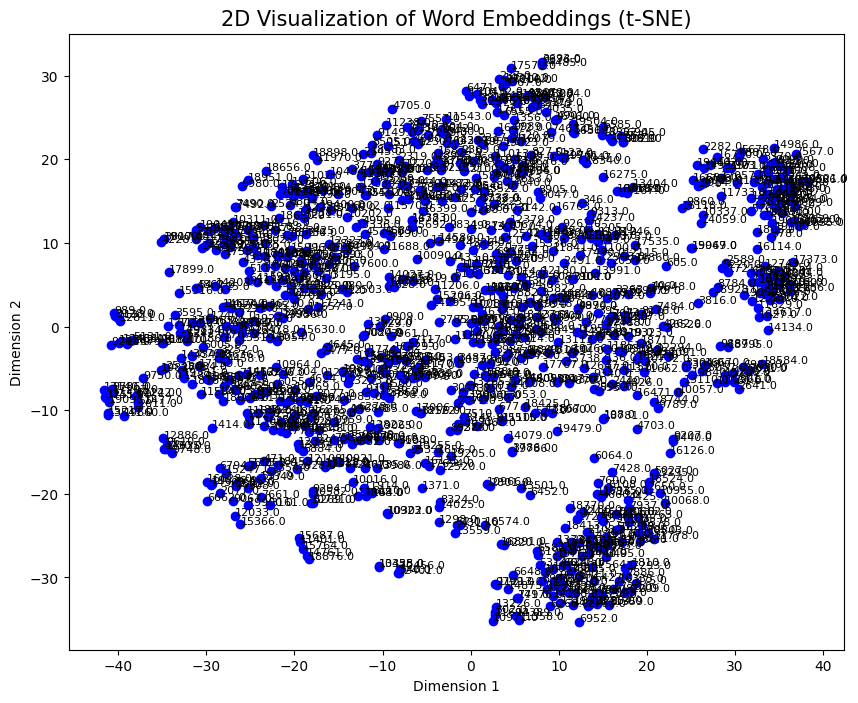


Word: critique
Occurrences: 982
Polysemy score: 0.0781
Review ID 16185.0: [-0.01382873  0.01122437 -0.00585696  0.01883032 -0.09429531]...
Review ID 15996.0: [-0.02343165  0.03229547  0.01313771  0.10836537 -0.13204518]...
Review ID 17293.0: [-0.03334171  0.20162328  0.10669877  0.02982313 -0.10824987]...
Review ID 10182.0: [ 0.02781678 -0.01715288 -0.11034043  0.1189685  -0.12415364]...
Review ID 1310.0: [ 0.02326467  0.07866608 -0.02562229  0.09534492 -0.13592713]...
Review ID 16334.0: [-0.00102542 -0.02897269 -0.16584854  0.07441393 -0.07297367]...
Review ID 13011.0: [-0.03633183 -0.03263077 -0.01333292  0.10441471 -0.1000617 ]...
Review ID 7350.0: [-0.06091013 -0.10624197 -0.06366629  0.0325258  -0.06159934]...
Review ID 10090.0: [-0.05293621 -0.08389452 -0.06538469  0.09880524 -0.0694157 ]...
Review ID 9376.0: [-0.01066144  0.05332845 -0.04994309  0.12751696 -0.19856268]...
Review ID 11238.0: [ 0.03775566 -0.05562027 -0.03334001  0.04516079 -0.14576276]...
Review ID 10110.0: [-0.

In [15]:
target_words = ['critique']
results = quick_polysemy_analysis(file_path, target_words, sample_size=1000)


Analyzing word: histoire


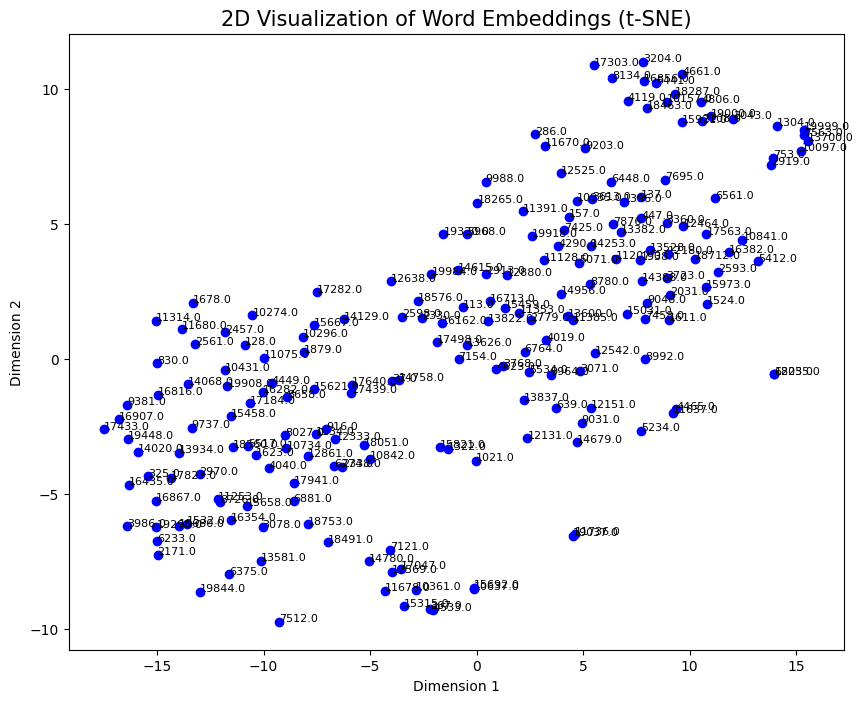


Word: histoire
Occurrences: 200
Polysemy score: 0.0975
Review ID 18753.0: [-0.00950986 -0.19498628  0.13899355  0.02429938 -0.12632746]...
Review ID 1938.0: [ 0.05326986  0.19551179  0.08023502  0.12502548 -0.10259068]...
Review ID 157.0: [ 0.07962727 -0.03809617  0.01287515  0.16828617 -0.0737323 ]...
Review ID 15459.0: [ 0.08218613  0.2400684   0.03087641  0.00305375 -0.09779622]...
Review ID 15031.0: [ 0.00800247  0.12871842 -0.04737178  0.06112363 -0.11164878]...
Review ID 18576.0: [ 0.06443074  0.10360884  0.03315109  0.00322903 -0.09731546]...
Review ID 17282.0: [-0.01854775  0.23152152  0.01772322 -0.01809511 -0.1454678 ]...
Review ID 17827.0: [-0.01907969  0.09586279  0.24356186 -0.04516999 -0.10293824]...
Review ID 13626.0: [ 0.0885423   0.09234277  0.03761729  0.0446177  -0.15743323]...
Review ID 12861.0: [ 0.00228591 -0.01079263  0.00302193 -0.03268277 -0.19462265]...
Review ID 12638.0: [ 0.04032521 -0.07022563  0.0073754  -0.07132894 -0.10436905]...
Review ID 4806.0: [ 0.0

In [16]:
target_words = ['histoire']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: histoire


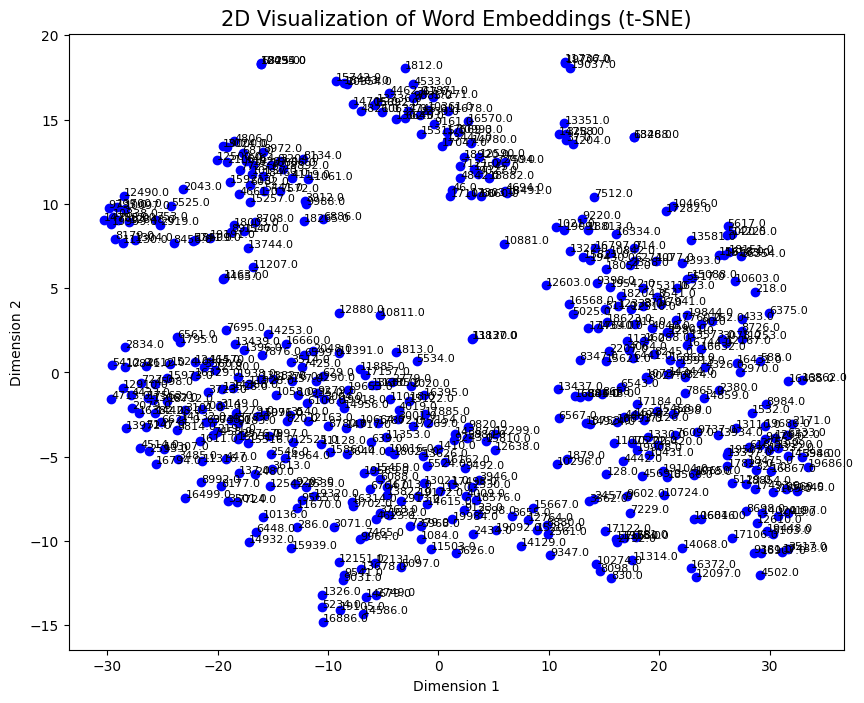


Word: histoire
Occurrences: 500
Polysemy score: 0.0954
Review ID 18753.0: [-0.00950986 -0.19498628  0.13899355  0.02429938 -0.12632746]...
Review ID 1938.0: [ 0.05326986  0.19551179  0.08023502  0.12502548 -0.10259068]...
Review ID 157.0: [ 0.07962727 -0.03809617  0.01287515  0.16828617 -0.0737323 ]...
Review ID 15459.0: [ 0.08218613  0.2400684   0.03087641  0.00305375 -0.09779622]...
Review ID 15031.0: [ 0.00800247  0.12871842 -0.04737178  0.06112363 -0.11164878]...
Review ID 18576.0: [ 0.06443074  0.10360884  0.03315109  0.00322903 -0.09731546]...
Review ID 17282.0: [-0.01854775  0.23152152  0.01772322 -0.01809511 -0.1454678 ]...
Review ID 17827.0: [-0.01907969  0.09586279  0.24356186 -0.04516999 -0.10293824]...
Review ID 13626.0: [ 0.0885423   0.09234277  0.03761729  0.0446177  -0.15743323]...
Review ID 12861.0: [ 0.00228591 -0.01079263  0.00302193 -0.03268277 -0.19462265]...
Review ID 12638.0: [ 0.04032521 -0.07022563  0.0073754  -0.07132894 -0.10436905]...
Review ID 4806.0: [ 0.0

In [17]:
target_words = ['histoire']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: histoire


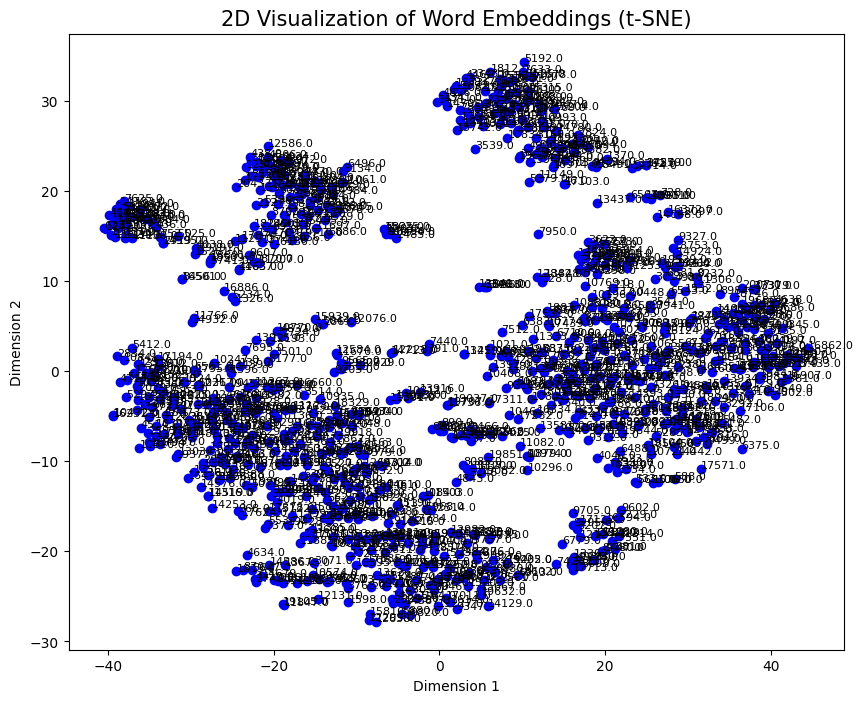


Word: histoire
Occurrences: 1000
Polysemy score: 0.0965
Review ID 18753.0: [-0.00950986 -0.19498628  0.13899355  0.02429938 -0.12632746]...
Review ID 1938.0: [ 0.05326986  0.19551179  0.08023502  0.12502548 -0.10259068]...
Review ID 157.0: [ 0.07962727 -0.03809617  0.01287515  0.16828617 -0.0737323 ]...
Review ID 15459.0: [ 0.08218613  0.2400684   0.03087641  0.00305375 -0.09779622]...
Review ID 15031.0: [ 0.00800247  0.12871842 -0.04737178  0.06112363 -0.11164878]...
Review ID 18576.0: [ 0.06443074  0.10360884  0.03315109  0.00322903 -0.09731546]...
Review ID 17282.0: [-0.01854775  0.23152152  0.01772322 -0.01809511 -0.1454678 ]...
Review ID 17827.0: [-0.01907969  0.09586279  0.24356186 -0.04516999 -0.10293824]...
Review ID 13626.0: [ 0.0885423   0.09234277  0.03761729  0.0446177  -0.15743323]...
Review ID 12861.0: [ 0.00228591 -0.01079263  0.00302193 -0.03268277 -0.19462265]...
Review ID 12638.0: [ 0.04032521 -0.07022563  0.0073754  -0.07132894 -0.10436905]...
Review ID 4806.0: [ 0.

In [18]:
target_words = ['histoire']
results = quick_polysemy_analysis(file_path, target_words, sample_size=1000)


Analyzing word: scène


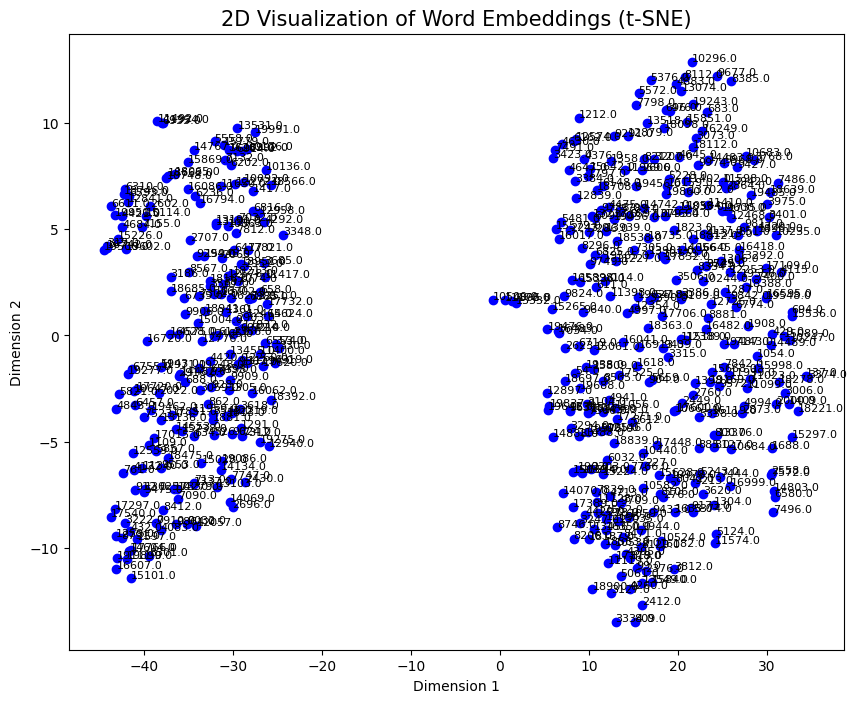


Word: scène
Occurrences: 500
Polysemy score: 0.2068
Review ID 1688.0: [ 0.06677295  0.11250214 -0.2827038  -0.06454395 -0.00475676]...
Review ID 15579.0: [ 0.18494612  0.08774553 -0.3072193   0.08257429 -0.01513079]...
Review ID 5659.0: [ 0.03530813 -0.10160945 -0.38042068 -0.00240866  0.18987286]...
Review ID 12879.0: [ 0.08282787 -0.06773527 -0.23702173  0.02695352 -0.01718043]...
Review ID 7910.0: [-0.02797293  0.28580242 -0.3463641  -0.04521069  0.01975717]...
Review ID 2065.0: [-0.04323471  0.18712446 -0.29931727  0.03175367  0.04706843]...
Review ID 18900.0: [-0.04687994  0.14312449 -0.390408   -0.09078172  0.03961331]...
Review ID 8471.0: [ 0.10646848 -0.17423606 -0.24323052 -0.04769592  0.02226955]...
Review ID 6477.0: [ 0.01646058  0.14227033 -0.22901404  0.11019108  0.02920611]...
Review ID 11574.0: [ 0.04785633  0.09576109 -0.06732987  0.02105306  0.11498975]...
Review ID 7090.0: [-0.05830609  0.11234143 -0.22758408  0.07865654  0.02592501]...
Review ID 4376.0: [ 0.13327318

In [19]:
target_words = ['scène']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: scène


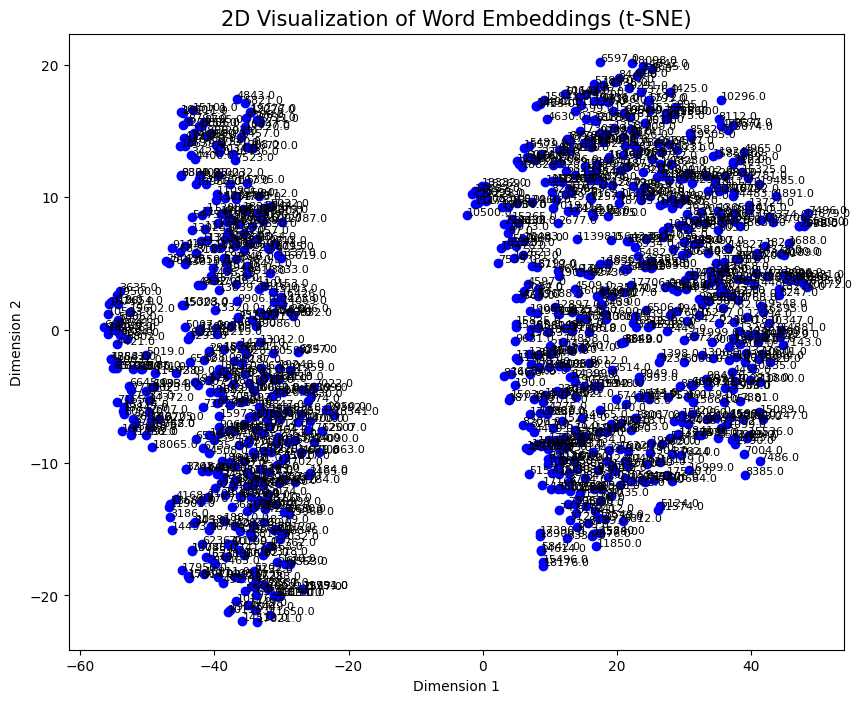


Word: scène
Occurrences: 1000
Polysemy score: 0.2066
Review ID 1688.0: [ 0.06677295  0.11250214 -0.2827038  -0.06454395 -0.00475676]...
Review ID 15579.0: [ 0.18494612  0.08774553 -0.3072193   0.08257429 -0.01513079]...
Review ID 5659.0: [ 0.03530813 -0.10160945 -0.38042068 -0.00240866  0.18987286]...
Review ID 12879.0: [ 0.08282787 -0.06773527 -0.23702173  0.02695352 -0.01718043]...
Review ID 7910.0: [-0.02797293  0.28580242 -0.3463641  -0.04521069  0.01975717]...
Review ID 2065.0: [-0.04323471  0.18712446 -0.29931727  0.03175367  0.04706843]...
Review ID 18900.0: [-0.04687994  0.14312449 -0.390408   -0.09078172  0.03961331]...
Review ID 8471.0: [ 0.10646848 -0.17423606 -0.24323052 -0.04769592  0.02226955]...
Review ID 6477.0: [ 0.01646058  0.14227033 -0.22901404  0.11019108  0.02920611]...
Review ID 11574.0: [ 0.04785633  0.09576109 -0.06732987  0.02105306  0.11498975]...
Review ID 7090.0: [-0.05830609  0.11234143 -0.22758408  0.07865654  0.02592501]...
Review ID 4376.0: [ 0.1332731

In [20]:
target_words = ['scène']
results = quick_polysemy_analysis(file_path, target_words, sample_size=1000)

### La corrélation entre la polysémie des mots issue du corpus et la polysémie lexicale en linguistique (référencée par les sens des mots dans WordNet).

In [1]:
import wn

# Télécharger et charger la partie française de Open Multilingual WordNet
wn.download('omw-fr:1.4')
french_wordnet = wn.Wordnet('omw-fr')

# Définir les mots cibles
mots_cibles = ["carte", "âge", "hauteur", "tour", "cœur", "critique", "histoire", "français", "scène"]

# Obtenir le nombre de sens des mots cibles
compte_lemmas = {}
for mot in mots_cibles:
    sens = french_wordnet.senses(mot)
    compte_lemmas[mot] = len(sens)

print("Nombre de sens des mots cibles :", compte_lemmas)


Cached file found: C:\Users\Dell\.wn_data\downloads\05d14d12c1a69d0b902a5425d2188c90ac9a82d4


Nombre de sens des mots cibles : {'carte': 18, 'âge': 10, 'hauteur': 10, 'tour': 18, 'cœur': 10, 'critique': 17, 'histoire': 8, 'français': 4, 'scène': 13}


Skipping omw-fr:1.4 (WOLF (Wordnet Libre du Français)); already addedml



Coefficient de corrélation de Pearson : 0.32646008940759147
Coefficient de corrélation de Spearman : 0.45305765077830235


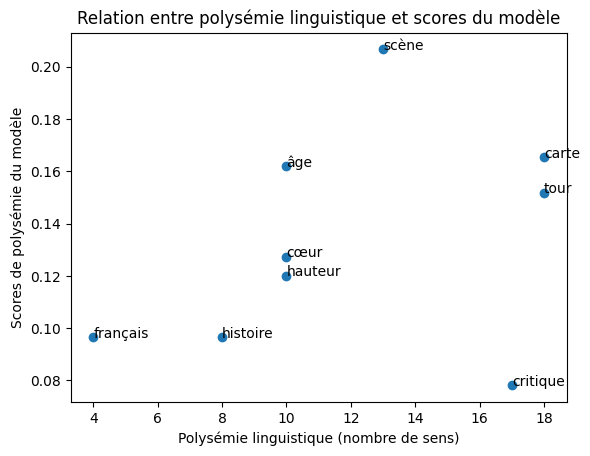

In [3]:
# Scores de polysémie calculés par le modèle
polysemy_scores = {
    "carte": 0.1653,
    "âge": 0.1619,
    "hauteur": 0.1200,
    "tour": 0.1518,
    "cœur": 0.1273,
    "critique": 0.0781,
    "histoire": 0.0965,
    "français": 0.0965,
    "scène": 0.2066
}

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

# Extraire les données
words = list(compte_lemmas.keys())
linguistic_values = [compte_lemmas[word] for word in words]
model_scores = [polysemy_scores[word] for word in words]

# Calculer les corrélations
pearson_corr, _ = pearsonr(linguistic_values, model_scores)
spearman_corr, _ = spearmanr(linguistic_values, model_scores)

print(f"Coefficient de corrélation de Pearson : {pearson_corr}")
print(f"Coefficient de corrélation de Spearman : {spearman_corr}")

# Tracer le nuage de points
plt.scatter(linguistic_values, model_scores)
plt.title("Relation entre polysémie linguistique et scores du modèle")
plt.xlabel("Polysémie linguistique (nombre de sens)")
plt.ylabel("Scores de polysémie du modèle")
for i, word in enumerate(words):
    plt.annotate(word, (linguistic_values[i], model_scores[i]))
plt.show()
